# SPIA Results

#### In this notebook, we get the number of recovered equivalent pathways from SPIA results and check for  concordance in their direction of activity. Recovered versus unrecovered equivalent pathway mappings from the results are also plotted.

In [1]:
import json
import os
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools as itt

from bio2bel_kegg import Manager as KeggManager
from bio2bel_reactome import Manager as ReactomeManager
from bio2bel_wikipathways import Manager as WikipathwaysManager

from pathway_forte.constants import *
from pathway_forte.pathway_enrichment.functional_class import *

In [2]:
# Initiate Bio2BEL manager to map pathway identifiers to names
kegg_manager = KeggManager()
reactome_manager = ReactomeManager()
wikipathways_manager = WikipathwaysManager()

In [4]:
brca_dataset = 'brca'
kirc_dataset = 'kirc'
lihc_dataset = 'lihc'
prad_dataset = 'prad'

In [5]:
def get_spia_results(dataset, p_value=None):
    """Get SPIA results for KEGG, Reactome and WikiPathways for a dataset from JSON file. 
    """
    SPIA = os.path.join(DATA, 'results', 'spia')
    
    kegg_path = os.path.join(SPIA, dataset, f'{dataset}_kegg_spia.csv')
    reactome_path = os.path.join(SPIA, dataset, f'{dataset}_reactome_spia.csv')
    wikipathways_path = os.path.join(SPIA, dataset, f'{dataset}_wikipathways_spia.csv')
    merged_path = os.path.join(SPIA, dataset, f'{dataset}_merged_spia.csv')

    kegg_df_total = pd.read_csv(kegg_path, sep=',')
    reactome_df_total = pd.read_csv(reactome_path, sep=',')
    wp_df_total = pd.read_csv(wikipathways_path, sep=',')
    merged_df_total = pd.read_csv(merged_path, sep=',')
    
    kegg_df = pd.DataFrame()
    reactome_df = pd.DataFrame()
    wp_df = pd.DataFrame()
    merged_df = pd.DataFrame()
    
    kegg_df['pathway_id'] = [('hsa0' + str(_id)) for _id in kegg_df_total['ID']]
    reactome_df['pathway_id'] = [('R-HSA-' + str(_id)) for _id in reactome_df_total['ID']]
    wp_df['pathway_id'] = [_id for _id in wp_df_total['ID']]
    merged_df['pathway_id'] = [_id for _id in merged_df_total['ID']]

    kegg_df['status'] = [i for i in kegg_df_total['Status']]
    reactome_df['status'] = [i for i in reactome_df_total['Status']]
    wp_df['status'] = [i for i in wp_df_total['Status']]
    merged_df['status'] = [i for i in merged_df_total['Status']]
    
    # get Bonferroni adjusted global p-value
    kegg_df['pGFWER'] = [i for i in kegg_df_total['pGFWER']]
    reactome_df['pGFWER'] = [i for i in reactome_df_total['pGFWER']]
    wp_df['pGFWER'] = [i for i in wp_df_total['pGFWER']]
    merged_df['pGFWER'] = [i for i in merged_df_total['pGFWER']]
        
    # Filter dataFrame to include only those pathways with an adjusted p-value less than X
    if p_value is not None:
        kegg_df = kegg_df.loc[kegg_df['pGFWER'] < p_value]
        reactome_df = reactome_df.loc[reactome_df['pGFWER'] < p_value]
        wp_df = wp_df.loc[wp_df['pGFWER'] < p_value]
        merged_df = merged_df.loc[merged_df['pGFWER'] < p_value]

        
    # sort dataFrame by Bonferroni adjusted global p-value
    kegg_df.sort_values('pGFWER', inplace=True)
    reactome_df.sort_values('pGFWER', inplace=True)
    wp_df.sort_values('pGFWER', inplace=True)
    merged_df.sort_values('pGFWER', inplace=True)

    return kegg_df, reactome_df, wp_df, merged_df


In [36]:
def get_spia_merged_statistics(merged_df, dataset):
    
    num_of_pathways = len(merged_df.index)
    merged_genesets = 0
    merged_kegg = 0
    merged_reactome = 0
    merged_wp = 0

    for pathway_id in merged_df['pathway_id']:
        
        if len(pathway_id) == 5 and not pathway_id.startswith('WP'):
            merged_kegg += 1
            
        elif len(pathway_id) > 5 and '|' not in pathway_id and not pathway_id.startswith('WP'):
            merged_reactome += 1
            
        elif pathway_id.startswith('WP') and '|' not in pathway_id:
            merged_wp += 1
            
        elif '|' in pathway_id:
            pathway_id.split('|')
            merged_genesets += 1

        else:
            raise ValueError(f'Invalid pathway ID {pathway_id}.')
            
    kegg_contributions_to_merged = merged_kegg / num_of_pathways * 100
    reactome_contributions_to_merged = merged_reactome / num_of_pathways * 100
    wikipathways_contributions_to_merged = merged_wp / num_of_pathways * 100
    proportion_of_merged_genesets = merged_genesets / num_of_pathways * 100
    
    print('For the {} pathways in the merged dataset results for {}:'.format(num_of_pathways, dataset))
    print('{0:.2f}% are from KEGG'.format(kegg_contributions_to_merged))
    print('{0:.2f}% are from Reactome'.format(reactome_contributions_to_merged))
    print('{0:.2f}% are from WikiPathways'.format(wikipathways_contributions_to_merged))
    print('{0:.2f}% are a combination of 2 or more databases'.format(proportion_of_merged_genesets))

In [37]:
brca_kegg_df, brca_reactome_df, brca_wp_df, brca_merged_df = get_spia_results('brca',0.05)
kirc_kegg_df, kirc_reactome_df, kirc_wp_df, kirc_merged_df = get_spia_results('kirc',0.05)
lihc_kegg_df, lihc_reactome_df, lihc_wp_df, lihc_merged_df = get_spia_results('lihc',0.05)
prad_kegg_df, prad_reactome_df, prad_wp_df, prad_merged_df = get_spia_results('prad',0.05)

In [38]:
get_spia_merged_statistics(brca_merged_df, 'BRCA')
get_spia_merged_statistics(kirc_merged_df, 'KIRC')
get_spia_merged_statistics(lihc_merged_df, 'LIHC')
get_spia_merged_statistics(prad_merged_df, 'PRAD')

For the 153 pathways in the merged dataset results for BRCA:
72.55% are from KEGG
8.50% are from Reactome
3.27% are from WikiPathways
15.69% are a combination of 2 or more databases
For the 150 pathways in the merged dataset results for KIRC:
75.33% are from KEGG
6.67% are from Reactome
2.00% are from WikiPathways
16.00% are a combination of 2 or more databases
For the 167 pathways in the merged dataset results for LIHC:
72.46% are from KEGG
8.98% are from Reactome
3.59% are from WikiPathways
14.97% are a combination of 2 or more databases
For the 148 pathways in the merged dataset results for PRAD:
76.35% are from KEGG
5.41% are from Reactome
3.38% are from WikiPathways
14.86% are a combination of 2 or more databases


In [14]:
brca_kegg_df = get_pathway_names('kegg',brca_kegg_df,kegg_manager=kegg_manager)
kirc_kegg_df = get_pathway_names('kegg',kirc_kegg_df,kegg_manager=kegg_manager)
lihc_kegg_df = get_pathway_names('kegg',lihc_kegg_df,kegg_manager=kegg_manager)
prad_kegg_df = get_pathway_names('kegg',prad_kegg_df,kegg_manager=kegg_manager)

In [15]:
brca_reactome_df = get_pathway_names('reactome',brca_reactome_df,reactome_manager=reactome_manager)
kirc_reactome_df = get_pathway_names('reactome',kirc_reactome_df,reactome_manager=reactome_manager)
lihc_reactome_df = get_pathway_names('reactome',lihc_reactome_df,reactome_manager=reactome_manager)
prad_reactome_df = get_pathway_names('reactome',prad_reactome_df,reactome_manager=reactome_manager)

In [16]:
brca_wp_df = get_pathway_names('wikipathways',brca_wp_df,wikipathways_manager=wikipathways_manager)
kirc_wp_df = get_pathway_names('wikipathways',kirc_wp_df,wikipathways_manager=wikipathways_manager)
lihc_wp_df = get_pathway_names('wikipathways',lihc_wp_df,wikipathways_manager=wikipathways_manager)
prad_wp_df = get_pathway_names('wikipathways',prad_wp_df,wikipathways_manager=wikipathways_manager)

Get equivalent pathways and their direction of change

In [17]:
brca_expected_mappings = get_pairwise_mappings(
    brca_kegg_df, 
    brca_reactome_df, 
    brca_wp_df, 
)
kirc_expected_mappings = get_pairwise_mappings(
    kirc_kegg_df, 
    kirc_reactome_df, 
    kirc_wp_df, 
)
lihc_expected_mappings = get_pairwise_mappings(
    lihc_kegg_df, 
    lihc_reactome_df, 
    lihc_wp_df, 
)
prad_expected_mappings = get_pairwise_mappings(
    prad_kegg_df, 
    prad_reactome_df, 
    prad_wp_df, 
)

Only equivalent pathway recovered and present in merged: ('kegg','hsa04622','Activated') and ('wikipathways', 'WP3865', 'Activated')

In [22]:
brca_actual_dict, brca_expected_dict = get_pairwise_mapping_numbers(
    brca_kegg_df, 
    brca_reactome_df, 
    brca_wp_df, 
)
kirc_actual_dict, kirc_expected_dict = get_pairwise_mapping_numbers(
    kirc_kegg_df, 
    kirc_reactome_df, 
    kirc_wp_df, 
)
lihc_actual_dict, lihc_expected_dict = get_pairwise_mapping_numbers(
    lihc_kegg_df, 
    lihc_reactome_df, 
    lihc_wp_df, 
)
prad_actual_dict, prad_expected_dict = get_pairwise_mapping_numbers(
    prad_kegg_df, 
    prad_reactome_df, 
    prad_wp_df, 
)

Plot how many pairwise pathways with mappings exist versus how many are expected

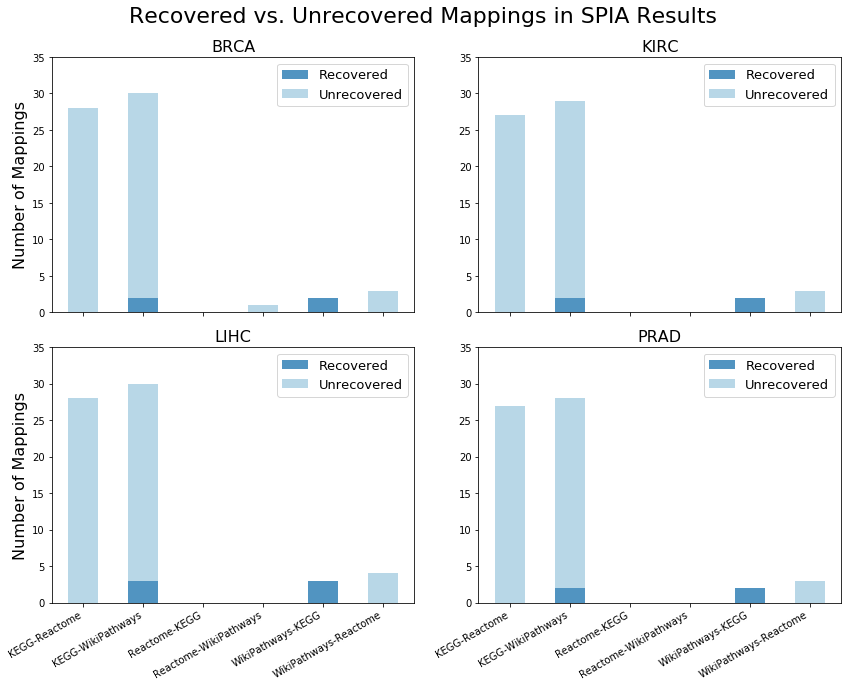

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
fig.suptitle('Recovered vs. Unrecovered Mappings in SPIA Results', fontsize=22)

N = 6
index = np.arange(N)
bar_width = 0.5
opacity = 0.8

pairings = ('KEGG-Reactome', 
 'KEGG-WikiPathways', 
 'Reactome-KEGG', 
 'Reactome-WikiPathways',
 'WikiPathways-KEGG', 
 'WikiPathways-Reactome',
)
label_font = {'size': 16}

plt.subplot(2, 2, 1)
actual_vals = list(brca_actual_dict.values())
expected_vals = list(brca_expected_dict.values())
difference = [x - y for x, y in zip(expected_vals, actual_vals)]

p1 = plt.bar(index, actual_vals, bar_width,alpha=opacity, color='#2679b2',label='Recovered')
p2 = plt.bar(index, difference, bar_width, bottom=actual_vals, alpha=opacity, color='#a7cee2',label='Unrecovered')

plt.title('BRCA', fontsize=16)
plt.ylabel('Number of Mappings', fontdict=label_font)
plt.xticks(index, pairings)
plt.ylim(0,35)
plt.legend(prop={'size':13},loc=1)


plt.subplot(2, 2, 2)
actual_vals = list(kirc_actual_dict.values())
expected_vals = list(kirc_expected_dict.values())
difference = [x - y for x, y in zip(expected_vals, actual_vals)]

p1 = plt.bar(index, actual_vals, bar_width,alpha=opacity, color='#2679b2',label='Recovered')
p2 = plt.bar(index, difference, bar_width, bottom=actual_vals, alpha=opacity, color='#a7cee2',label='Unrecovered')

plt.title('KIRC', fontsize=16)
plt.xticks(index, pairings)
plt.ylim(0,35)
plt.legend(prop={'size':13},loc=1)

plt.subplot(2, 2, 3)
actual_vals = list(lihc_actual_dict.values())
expected_vals = list(lihc_expected_dict.values())
difference = [x - y for x, y in zip(expected_vals, actual_vals)]

p1 = plt.bar(index, actual_vals, bar_width,alpha=opacity, color='#2679b2',label='Recovered')
p2 = plt.bar(index, difference, bar_width, bottom=actual_vals, alpha=opacity, color='#a7cee2',label='Unrecovered')

plt.title('LIHC', fontsize=16)
plt.ylabel('Number of Mappings', fontdict=label_font)
plt.xticks(index, pairings)
plt.ylim(0,35)
plt.legend(prop={'size':13},loc=1)

plt.subplot(2, 2, 4)
actual_vals = list(prad_actual_dict.values())
expected_vals = list(prad_expected_dict.values())
difference = [x - y for x, y in zip(expected_vals, actual_vals)]

p1 = plt.bar(index, actual_vals, bar_width,alpha=opacity, color='#2679b2',label='Recovered')
p2 = plt.bar(index, difference, bar_width, bottom=actual_vals, alpha=opacity, color='#a7cee2',label='Unrecovered')

plt.title('PRAD', fontsize=16)
plt.ylim(0,35)
plt.xticks(index, pairings)
plt.legend(prop={'size':13},loc=1)

fig.autofmt_xdate()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('pairwise_mappings_spia.png',dpi=250)
plt.show()